# Tutorial 4: Stereo-seq mouse olfactory bulb

This tutorial demonstrates how to identify spatial domains on Stereo-seq data.

In this tutorial, we foucs on the Stereo-seq mouse olfactory bulb data (https://github.com/JinmiaoChenLab/SEDR_analyses/).

We removed spots outside the main tissue area, and the used spots can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

In [4]:
counts_file = os.path.join('Data/RNA_counts.tsv')
coor_file = os.path.join('Data/position.tsv')

In [5]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)

(27106, 19527) (19527, 3)


In [6]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [7]:
coor_df.head()

,x,y
label,,
Spot_1,12555.007833,6307.537859
Spot_2,12623.666667,6297.166667
Spot_3,12589.567164,6302.552239
Spot_4,12642.495050,6307.386139
Spot_5,13003.333333,6307.990991


In [8]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()

In [9]:
adata

AnnData object with n_obs × n_vars = 19527 × 27106

In [10]:
coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()
sc.pp.calculate_qc_metrics(adata, inplace=True)

(6002.432692307693, 12486.580128205129, 9908.545833333334, 15086.093055555555)

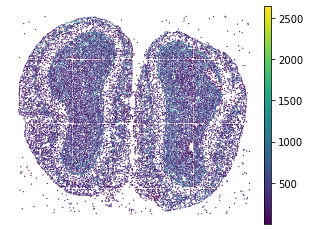

In [11]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [12]:
used_barcode = pd.read_csv(os.path.join('Data/used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

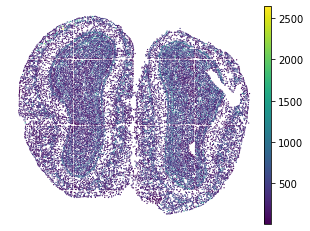

In [14]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [15]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

Trying to set attribute `.var` of view, copying.


After flitering:  (19109, 14376)


In [16]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.


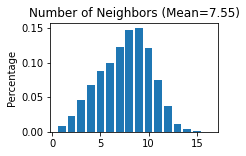

In [17]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata)

## Running STAGATE

In [18]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (19109, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [12:33<00:00,  1.51s/it]


In [19]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [20]:
sc.tl.louvain(adata, resolution=0.8)

(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

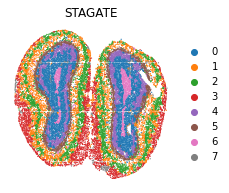

In [21]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='STAGATE')
plt.axis('off')

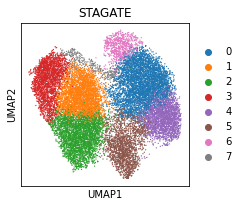

In [22]:
sc.pl.umap(adata, color='louvain', title='STAGATE')

## SCANPY results (for comparison)

In [23]:
sc.pp.pca(adata, n_comps=30)

In [24]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.louvain(adata, resolution=0.8)
sc.tl.umap(adata)

(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

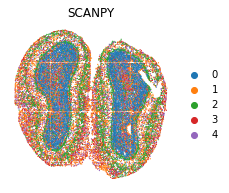

In [25]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='SCANPY')
plt.axis('off')

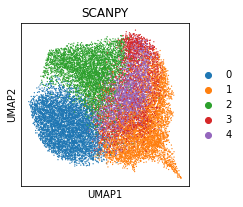

In [26]:
sc.pl.umap(adata, color='louvain', title='SCANPY')